<a href="https://colab.research.google.com/github/Elman295/Kaggle_Image_localization/blob/main/Kaggle_Image_localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:

! mkdir ~/.kaggle


In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! kaggle datasets download -d mbkinaci/image-localization-dataset

 56% 3.00M/5.40M [00:00<00:00, 5.59MB/s]
100% 5.40M/5.40M [00:00<00:00, 7.69MB/s]


In [69]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision import models
from torch.utils.data import DataLoader, Dataset
from torch import nn
from torchsummary import summary

#=============================================================
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patch
import os
import zipfile
import glob
import xml.etree.ElementTree as ET
from PIL import Image


In [70]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [71]:
with zipfile.ZipFile("image-localization-dataset.zip","r") as f:
  f.extractall("data")

In [72]:
data = os.path.join("data","training_images")

In [73]:
images = glob.glob(os.path.join("data","training_images","*.jpg"))
xml_files = glob.glob(os.path.join("data","training_images","*.xml"))

In [74]:
images.sort()

In [75]:
images

['data/training_images/cucumber_1.jpg',
 'data/training_images/cucumber_10.jpg',
 'data/training_images/cucumber_11.jpg',
 'data/training_images/cucumber_12.jpg',
 'data/training_images/cucumber_13.jpg',
 'data/training_images/cucumber_14.jpg',
 'data/training_images/cucumber_15.jpg',
 'data/training_images/cucumber_16.jpg',
 'data/training_images/cucumber_17.jpg',
 'data/training_images/cucumber_18.jpg',
 'data/training_images/cucumber_19.jpg',
 'data/training_images/cucumber_2.jpg',
 'data/training_images/cucumber_20.jpg',
 'data/training_images/cucumber_21.jpg',
 'data/training_images/cucumber_22.jpg',
 'data/training_images/cucumber_23.jpg',
 'data/training_images/cucumber_24.jpg',
 'data/training_images/cucumber_25.jpg',
 'data/training_images/cucumber_26.jpg',
 'data/training_images/cucumber_27.jpg',
 'data/training_images/cucumber_28.jpg',
 'data/training_images/cucumber_29.jpg',
 'data/training_images/cucumber_3.jpg',
 'data/training_images/cucumber_30.jpg',
 'data/training_ima

In [76]:
xml_files.sort()

In [77]:
xml_files

['data/training_images/cucumber_1.xml',
 'data/training_images/cucumber_10.xml',
 'data/training_images/cucumber_11.xml',
 'data/training_images/cucumber_12.xml',
 'data/training_images/cucumber_13.xml',
 'data/training_images/cucumber_14.xml',
 'data/training_images/cucumber_15.xml',
 'data/training_images/cucumber_16.xml',
 'data/training_images/cucumber_17.xml',
 'data/training_images/cucumber_18.xml',
 'data/training_images/cucumber_19.xml',
 'data/training_images/cucumber_2.xml',
 'data/training_images/cucumber_20.xml',
 'data/training_images/cucumber_21.xml',
 'data/training_images/cucumber_22.xml',
 'data/training_images/cucumber_23.xml',
 'data/training_images/cucumber_24.xml',
 'data/training_images/cucumber_25.xml',
 'data/training_images/cucumber_26.xml',
 'data/training_images/cucumber_27.xml',
 'data/training_images/cucumber_28.xml',
 'data/training_images/cucumber_29.xml',
 'data/training_images/cucumber_3.xml',
 'data/training_images/cucumber_30.xml',
 'data/training_ima

In [78]:
tree = ET.parse(xml_files[0])

In [79]:
root = tree.getroot()

In [80]:
root.tag

'annotation'

In [81]:
for children in root:
  print(children.tag, "and  ", children.attrib)

folder and   {}
filename and   {}
path and   {}
source and   {}
size and   {}
segmented and   {}
object and   {}


In [82]:
int(root[6][4][0].text)

23

In [83]:
def make_data_from_xml(file_xml):
  bbx = []
  for file in file_xml:
    tree = ET.parse(file)
    root = tree.getroot()
    bbx.append((int(root[6][4][0].text), int(root[6][4][1].text), int(root[6][4][2].text), int(root[6][4][3].text)))

  return bbx



In [84]:
bbx = make_data_from_xml(xml_files)

In [85]:
bbx[0:10]

[(23, 42, 206, 199),
 (13, 70, 219, 160),
 (8, 42, 221, 200),
 (22, 67, 218, 158),
 (15, 56, 212, 156),
 (24, 82, 204, 154),
 (40, 89, 216, 221),
 (14, 44, 208, 205),
 (28, 71, 193, 174),
 (53, 86, 149, 175)]

In [86]:
def find_class(image_file):
  cucumber = []
  eggplant = []
  mushroom = []

  for i in image_file:
    if "cucumber" in i:
      cucumber.append(i)
    if "eggplant" in image_file:
      eggplant.append(i)
    if "mushroom" in image_file:
      mushroom.append(i)


  return cucumber, eggplant, mushroom


In [87]:
c,e,m = find_class(images)

In [88]:
c[:5]

['data/training_images/cucumber_1.jpg',
 'data/training_images/cucumber_10.jpg',
 'data/training_images/cucumber_11.jpg',
 'data/training_images/cucumber_12.jpg',
 'data/training_images/cucumber_13.jpg']

In [89]:
class Local_data(Dataset):

  def __init__(self, xml_files, images, transform = None, target = None):
    self.xml_files = xml_files
    self.images = images
    self.transform = transform
    self.target = target


  def __len__(self):
    return len(self.images)


  def __getitem__(self, idx):
    xml_file = make_data_from_xml(self.xml_files)
    image, xml_file = self.images[idx], xml_file[idx]


    c,e,m = find_class(self.images)
    if image in c:
      self.target = 0
    if image in e:
      self.target = 1
    if image in m:
      self.target = 2



    image = Image.open(image).convert("RGB")
    y_min = xml_file[1]
    x_min = xml_file[0]
    y_max = xml_file[3]
    x_max = xml_file[2]

    width = x_max - x_min
    height = y_max - y_min

    if self.transform is not None:
      image = self.transform(image)

    return image, torch.tensor((x_min, y_min, width, height), dtype=torch.float32), torch.tensor(self.target)



In [90]:
tfms = transforms.Compose([

      transforms.Resize(size = (227,227)),
      transforms.ToTensor()

])

In [91]:
data = Local_data(xml_files, images, transform = tfms)

In [92]:
data[1]

(tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
          [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
          [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
          ...,
          [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
          [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
          [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961]],
 
         [[0.9882, 0.9882, 0.9882,  ..., 0.9882, 0.9882, 0.9882],
          [0.9882, 0.9882, 0.9882,  ..., 0.9882, 0.9882, 0.9882],
          [0.9882, 0.9882, 0.9882,  ...,

In [93]:
def show_result(image, x, y, w, h, target):

  image = np.transpose(image,(1,2,0))
  fig, ax = plt.subplots()

# Display the image
  ax.imshow(image)

# Create a Rectangle patch
  rect = patch.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
  ax.add_patch(rect)
  labels = {
      0 :"cucumber",
      1:"eggplant",
      2:"mushroom"
  }
  plt.xlabel(labels[target])

  plt.show()


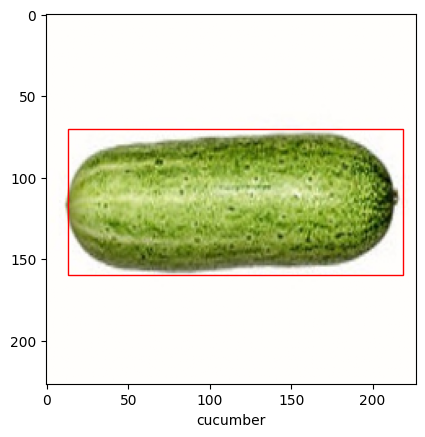

In [94]:
show_result(data[1][0], 13,70,206,90, 0)

In [95]:
train_data, test_data = torch.utils.data.random_split(data, lengths=[0.8,0.2])

In [96]:
train_dl = DataLoader(train_data, batch_size = 16, shuffle = True)
test_dl = DataLoader(test_data, batch_size = 16, shuffle=False)

In [97]:
class Detector(nn.Module):

  def __init__(self, model):
    super(Detector,self).__init__()
    model.fc = nn.Sequential(

        nn.Linear(model.fc.in_features, 128),
        nn.BatchNorm1d(128),
        nn.ReLU()
    )

    self.model = model

    self.scores = nn.Linear(128,3)
    self.locals = nn.Linear(128,4)

  def forward(self, x):
    x = self.model(x)
    scores = self.scores(x)
    local = self.locals(x)
    return scores, local

In [98]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
net = Detector(model)
net.to(device)
summary(net, input_size=(3,277,277), batch_size = 16)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 64, 139, 139]           9,408
       BatchNorm2d-2         [16, 64, 139, 139]             128
              ReLU-3         [16, 64, 139, 139]               0
         MaxPool2d-4           [16, 64, 70, 70]               0
            Conv2d-5           [16, 64, 70, 70]          36,864
       BatchNorm2d-6           [16, 64, 70, 70]             128
              ReLU-7           [16, 64, 70, 70]               0
            Conv2d-8           [16, 64, 70, 70]          36,864
       BatchNorm2d-9           [16, 64, 70, 70]             128
             ReLU-10           [16, 64, 70, 70]               0
       BasicBlock-11           [16, 64, 70, 70]               0
           Conv2d-12           [16, 64, 70, 70]          36,864
      BatchNorm2d-13           [16, 64, 70, 70]             128
             ReLU-14           [16, 64,

In [99]:
loss_fn_scores = nn.CrossEntropyLoss()


In [100]:
class Loss_local(nn.Module):

  def __init__(self):
    super(Loss_local, self).__init__()
    self.mse = nn.MSELoss()

  def forward(self,x_p,y_p,w_p,h_p, x,y,w,h):

    loss_1 = self.mse(x_p, x)
    loss_2 = self.mse(y_p, y)
    loss_3 = self.mse(w_p, w)
    loss_4 =self.mse(h_p, h)

    return loss_1 + loss_2 + loss_3 + loss_4


In [101]:
loss_fn_local = Loss_local()

In [102]:
opt = torch.optim.Adam(params = net.parameters(), lr = 1e-3)

In [103]:
def train(data, model, loss_fn_local, loss_fn_score, opt):

  model.train()

  size = len(data.dataset)
  for batch, (image, local, target) in enumerate(data):
    image = image.to(device)
    local = local.to(device)
    target = target.to(device)

    y_pred, local_pred = model(image)
    loss_score = loss_fn_scores(y_pred, target)

    loss_local = loss_fn_local(local_pred[0], local_pred[1],local_pred[2],local_pred[3], local[0],local[1],local[2],local[3])
    loss = loss_score + loss_local



    opt.zero_grad()
    loss.backward()
    opt.step()


    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(image)
      print(f"loss:{loss} current [{current} / {size}]")

In [104]:
def test(data, model, loss_fn_scores, loss_fn_local):
  model.eval()
  size = len(data.dataset)
  num_batch = len(data)

  test_loss, correct = 0,0

  with torch.no_grad():
    for (image, local, target) in data:
      image = image.to(device)
      local = local.to(device)
      target = target.to(device)
      y_pred, local_pred = model(image)
      test_loss += loss_fn_scores(y_pred, target).item() +loss_fn_local(local_pred[0], local_pred[1],local_pred[2],local_pred[3], local[0],local[1],local[2],local[3]).item()
      correct += (y_pred.argmax(1) == target).type(torch.float).sum().item()

    correct /= size
    test_loss /= num_batch

    print(f"Accuracy is {correct * 100} loss {test_loss}")


In [105]:
EPOCHS = 200

for epoch in range(EPOCHS):
  print(f"epoch {epoch +1}=-=-==-=-==-")
  train(train_dl, net, loss_fn_local,loss_fn_scores, opt)
  test(test_dl,net,loss_fn_scores, loss_fn_local)

print("done")

epoch 1=-=-==-=-==-
loss:50109.0078125 current [0 / 149]
Accuracy is 100.0 loss 80539.04962293926
epoch 2=-=-==-=-==-
loss:53132.921875 current [0 / 149]
Accuracy is 100.0 loss 53014.306341072974
epoch 3=-=-==-=-==-
loss:54763.60546875 current [0 / 149]
Accuracy is 100.0 loss 45865.20397110904
epoch 4=-=-==-=-==-
loss:68045.96875 current [0 / 149]
Accuracy is 100.0 loss 44404.96754655242
epoch 5=-=-==-=-==-
loss:46104.01171875 current [0 / 149]
Accuracy is 100.0 loss 44085.534491776176
epoch 6=-=-==-=-==-
loss:55201.3671875 current [0 / 149]
Accuracy is 100.0 loss 43269.258007280216
epoch 7=-=-==-=-==-
loss:47019.51171875 current [0 / 149]
Accuracy is 100.0 loss 43245.208611528076
epoch 8=-=-==-=-==-
loss:53993.2578125 current [0 / 149]
Accuracy is 100.0 loss 42990.87263191367
epoch 9=-=-==-=-==-
loss:53546.2734375 current [0 / 149]
Accuracy is 100.0 loss 40864.99667703783
epoch 10=-=-==-=-==-
loss:55148.24609375 current [0 / 149]
Accuracy is 100.0 loss 43341.9341487959
epoch 11=-=-==-

In [114]:
test_dl = DataLoader(test_data, batch_size = 1, shuffle = False)

In [115]:
image,local,target = next(iter(test_dl))

In [116]:
image.to(device)
local.to(device)
target.to(device)

tensor([0], device='cuda:0')

In [118]:
target_p, local_p = net(image.to(device))

In [119]:
image.shape

torch.Size([1, 3, 227, 227])

In [120]:
local.squeeze(0)

tensor([  8.,  42., 213., 158.])

In [121]:
local_p

tensor([[ 27.5329,  59.9134, 186.6364, 128.6922]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

KeyError: ignored

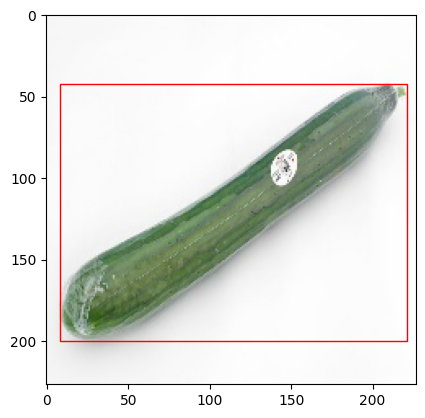

In [123]:
show_result(image.squeeze(0), 8,42,213,158, target.squeeze(0))

KeyError: ignored

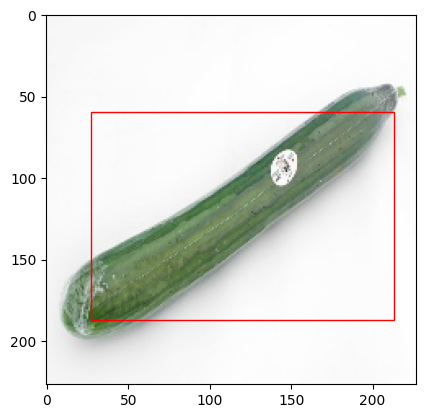

In [124]:
show_result(image.squeeze(0), 27,59,186,128, target.squeeze(0))